In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 300)

import matplotlib.pyplot as plt
%matplotlib inline

**Alle Haltestellen**

In [2]:
sr = pd.read_csv(r'C:\Users\wnd\PycharmProjects\ StopStructuring\MyStopReport.csv', delimiter=';', encoding='UTF-8', header=0)
sr.shape

(32690, 18)

**Nur auf schweizer Haltestellen reduzieren** (im ID-Bereicht 85xxxxx)

In [3]:
sr = sr.loc[(sr.station_id >= 8500000) & (sr.station_id <= 8599999), :]
sr.shape

(25743, 18)

Feature **vehicle_types_count** - Anzahl der VM-Typen, die an dieser Haltestelle verkehren

In [4]:
sr['vehicle_types_count'] = (sr.iloc[:, 3:11] != 0).sum(axis=1)

Feature **vehicles_count** - Summe aller VM, die an dieser Haltestelle verkehren 

In [5]:
sr['vehicles_count'] = sr.iloc[:, 3:11].sum(axis=1)

Spalten anders ordnen

In [6]:
sr = sr[['station_id', 'station_name', 'mobihub_id', 'Zug', 'Bergbahn', 'Bus', 'Tram', 'Taxi', 'Schiff', 'Metro', 'Aufzug', 'vehicles_count', 'vehicle_types_count', 'metabhf_count', 'metabhf_relations', 'platforms_count', 'as_start_count', 'as_end_count', 'lat', 'long']]

Wieviele Haltestellen gibt es, die von keinem VM bedient werden?

In [7]:
not_operated_stops = sr.loc[(sr.vehicles_count == 0), :]

In [8]:
not_operated_stops.shape[0]

206

In [9]:
not_operated_stops.loc[:, 'station_id':'as_end_count'].head(5)

,station_id,station_name,mobihub_id,Zug,Bergbahn,Bus,Tram,Taxi,Schiff,Metro,Aufzug,vehicles_count,vehicle_types_count,metabhf_count,metabhf_relations,platforms_count,as_start_count,as_end_count
4740,8500019,Schweizerhalle,8500019,0,0,0,0,0,0,0,0,0,0,1,8588069-(15min),0,0,0
4756,8500038,Basel St. Jakob,8500038,0,0,0,0,0,0,0,0,0,0,1,8588943-(8min),0,0,0
4774,8500078,Dornach,8500078,0,0,0,0,0,0,0,0,0,0,2,8500118-(2min) 8500692-(2min),0,0,0
4776,8500080,Talhaus,8500080,0,0,0,0,0,0,0,0,0,0,1,8578258-(2min),0,0,0
4777,8500081,Altmarkt,8500081,0,0,0,0,0,0,0,0,0,0,1,8578321-(3min),0,0,0


Datensatz bereinigen - not_operated_stops löschen

In [10]:
sr.shape

(25743, 20)

In [11]:
sr.drop(not_operated_stops.index, inplace=True)

In [12]:
sr.shape

(25537, 20)

Haltestellen, die von einem Zug angefahren werden, aber keinen Bahnsteig aufweisen (fehlende Daten)

In [13]:
sr.loc[(sr.platforms_count == 0) & (sr.Zug != 0), :].shape[0]

931

In [14]:
sr.loc[(sr.platforms_count == 0) & (sr.Zug != 0), :].head(10)

,station_id,station_name,mobihub_id,Zug,Bergbahn,Bus,Tram,Taxi,Schiff,Metro,Aufzug,vehicles_count,vehicle_types_count,metabhf_count,metabhf_relations,platforms_count,as_start_count,as_end_count,lat,long
4793,8500100,Tavannes,8500100,155,0,10,0,0,0,0,0,165,2,1,8571938-(2min),0,34,34,47.219845,7.201645
4794,8500101,Reconvilier,8500101,87,0,10,0,0,0,0,0,97,2,1,8571953-(2min),0,0,0,47.235238,7.227418
4795,8500102,Malleray-Bévilard,8500102,87,0,10,0,0,0,0,0,97,2,1,8589220-(2min),0,10,9,47.238714,7.275946
4796,8500103,Sorvilier,8500103,68,0,10,0,0,0,0,0,78,2,1,8582684-(0min),0,0,0,47.239247,7.305774
4797,8500104,Court,8500104,68,0,10,0,0,0,0,0,78,2,1,8582682-(0min),0,0,0,47.240601,7.342110
4811,8500124,St-Ursanne,8500124,175,0,14,0,0,0,0,0,189,2,1,8572034-(2min),0,0,0,47.367703,7.165957
4814,8500127,Courtemaîche,8500127,78,0,13,0,0,0,0,0,91,2,2,8581834-(2min) 8583779-(0min),0,0,0,47.455869,7.055380
4817,8500135,Pontenet,8500135,87,0,10,0,0,0,0,0,97,2,1,8589219-(0min),0,0,0,47.238848,7.254159
4828,8500162,Tramelan-Dessous,None,68,0,0,0,0,0,0,0,68,1,0,NaN,0,0,0,47.222441,7.112690
4829,8500164,Tramelan-Chalet,8500164,44,0,0,0,0,0,0,0,44,1,1,8571925-(0min),0,0,0,47.223460,7.092451


Haltestellen mit METABHF-Beziehungen und die Umstiegszeiten

In [15]:
import re

In [16]:
def get_zeit(s):
    r = re.compile(r'.+\((\d{1,2})min\)')
    m = r.match(s)
    return int(m.group(1))
    
def get_max_zeit(station_id):
    relations = sr.loc[sr.station_id == station_id].metabhf_relations.values[0]
    if isinstance(relations, str):
        return max([get_zeit(s) for s in relations.split() if s != None])
    else:
        return None
    

In [17]:
sr.metabhf_relations.isna().sum()

21030

In [18]:
sr['max_transfer_time'] = sr.loc[sr.metabhf_relations.isna() == False, :].station_id.map(get_max_zeit)

In [19]:
sr = sr[['station_id', 'station_name', 'mobihub_id', 'Zug', 'Bergbahn', 'Bus', 'Tram', 'Taxi', 'Schiff', 'Metro', 'Aufzug', 'vehicles_count', 'metabhf_count', 'metabhf_relations', 'max_transfer_time', 'platforms_count', 'as_start_count', 'as_end_count', 'lat', 'long']]

In [20]:
sr.loc[:, ['station_id', 'station_name', 'max_transfer_time']].sort_values(by='max_transfer_time', ascending=False)

,station_id,station_name,max_transfer_time
10117,8508399,Engelberg,50.0
11153,8530368,Engelberg (Fürenalp Bahn),50.0
10848,8509967,"Davos Wiesen, Kirche",45.0
10137,8508472,Sisikon (See),45.0
10138,8508473,Tellsplatte,45.0
...,...,...,...
30472,8596120,"Le Châtelard FR, La Perreire",NaN
30473,8596121,"Bouloz, Les Esserts",NaN
30474,8596122,"Lengnau BE, Industrie",NaN
30475,8596123,"Goldach, Klosterstrasse",NaN


<AxesSubplot:>

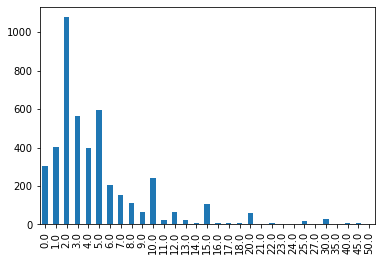

In [21]:
sr.max_transfer_time.value_counts().sort_index().plot(kind='bar')

In [22]:
transfer_time_overmuch = sr.loc[sr.max_transfer_time > 15, :]
transfer_time_overmuch.shape

(156, 20)

In [23]:
transfer_time_overmuch.head(10)

,station_id,station_name,mobihub_id,Zug,Bergbahn,Bus,Tram,Taxi,Schiff,Metro,Aufzug,vehicles_count,metabhf_count,metabhf_relations,max_transfer_time,platforms_count,as_start_count,as_end_count,lat,long
4897,8500264,Oberdorf SO,8500264,138,0,20,0,0,0,0,0,158,3,8500456-(30min) 8530671-(5min) 8583049-(2min),30.0,1,20,20,47.235883,7.493696
4938,8500456,"Oberdorf SO, Endhalt",8500264,0,0,194,0,0,0,0,0,194,2,8500264-(30min) 8530671-(30min),30.0,0,99,92,47.230224,7.500928
5242,8501014,Mies,8501014,532,0,0,0,0,0,0,0,532,2,8587078-(20min) 8596097-(2min),20.0,2,0,0,46.298489,6.167655
5251,8501033,Rolle,8501033,777,0,0,0,0,0,0,0,777,3,8501320-(24min) 8570034-(1min) 8583501-(1min),24.0,2,0,0,46.462746,6.336404
5277,8501072,Thonon-les-Bains (F) (lac),1400016,0,0,0,0,0,92,0,0,92,5,1400016-(20min) 1400020-(25min) 1401273-(15min) 8774564-(30min) 8799800-(0min),30.0,0,42,47,46.375112,6.476694
5278,8501074,Evian-les-Bains (F) (lac),8501074,0,0,0,0,0,86,0,0,86,2,8774567-(30min) 8799801-(0min),30.0,0,43,40,46.401594,6.594780
5454,8501320,Rolle (lac),8501033,0,0,0,0,0,9,0,0,9,2,8501033-(24min) 8570034-(24min),24.0,0,0,0,46.454990,6.337281
5462,8501328,"Ardon, centre",8501328,0,0,107,0,0,0,0,0,107,1,8501505-(18min),18.0,0,0,0,46.211605,7.258028
5479,8501347,"Les Moulins, village",8501347,0,0,80,0,0,0,0,0,80,1,8501393-(18min),18.0,0,3,2,46.460746,7.106310
5517,8501393,La Chaudanne-Les Moulins,8501347,43,0,0,0,0,0,0,0,43,1,8501347-(18min),18.0,0,0,0,46.466052,7.096735


Feature **corr_metabhf_count**
korrigierte Anzahl der Metabahnhof-Beziehungen

In [24]:
def get_corrected_metabhf_count(station_id):
    relations = sr.loc[sr.station_id == station_id].metabhf_relations.values[0]
    if isinstance(relations, str):
        return len([get_zeit(s) for s in relations.split() if get_zeit(s) <= 12]) # nur die Umstiegszeit <= 12 min berücksichtigen
    else:
        return 0

In [25]:
sr['corr_metabhf_count'] = sr.station_id.map(get_corrected_metabhf_count)

In [26]:
sr.loc[transfer_time_overmuch.index, ['station_id', 'station_name', 'metabhf_relations', 'metabhf_count', 'corr_metabhf_count']].head(10)

,station_id,station_name,metabhf_relations,metabhf_count,corr_metabhf_count
4897,8500264,Oberdorf SO,8500456-(30min) 8530671-(5min) 8583049-(2min),3,2
4938,8500456,"Oberdorf SO, Endhalt",8500264-(30min) 8530671-(30min),2,0
5242,8501014,Mies,8587078-(20min) 8596097-(2min),2,1
5251,8501033,Rolle,8501320-(24min) 8570034-(1min) 8583501-(1min),3,2
5277,8501072,Thonon-les-Bains (F) (lac),1400016-(20min) 1400020-(25min) 1401273-(15min) 8774564-(30min) 8799800-(0min),5,1
5278,8501074,Evian-les-Bains (F) (lac),8774567-(30min) 8799801-(0min),2,1
5454,8501320,Rolle (lac),8501033-(24min) 8570034-(24min),2,0
5462,8501328,"Ardon, centre",8501505-(18min),1,0
5479,8501347,"Les Moulins, village",8501393-(18min),1,0
5517,8501393,La Chaudanne-Les Moulins,8501347-(18min),1,0


In [27]:
ref = sr.loc[sr.station_id.isin([8500010, 8578143, 8507110, 8509000, 8581044, 8575112, 8509073, 8575116, 8579253, 8501181, 8591818, 8501300, 8593929, 8593938, 8589455, 8579695, 8506002, 8590997, 8591038])]

In [32]:
ref.sort_values(by=['vehicles_count'], ascending=False)

,station_id,station_name,mobihub_id,Zug,Bergbahn,Bus,Tram,Taxi,Schiff,Metro,Aufzug,vehicles_count,metabhf_count,metabhf_relations,max_transfer_time,platforms_count,as_start_count,as_end_count,lat,long,corr_metabhf_count
9277,8507110,"Bern, Zytglogge",None,0,0,4203,4360,0,0,0,0,8563,0,NaN,NaN,7,39,47,46.947840,7.447500,0
18559,8578143,"Basel, Bahnhof SBB",0000022,0,0,1980,4491,0,0,0,0,6471,3,8500010-(6min) 8502052-(7min) 8500146-(0min),7.0,10,1286,1303,47.548285,7.590297,3
26945,8591818,"Lausanne-Flon, pl. de l'Europe",8501181,0,0,1981,0,0,0,3277,0,5258,4,8501181-(3min) 8579253-(5min) 8579254-(4min) 8591988-(3min),5.0,0,1472,1511,46.520324,6.630473,4
26248,8591038,"Zürich, Albisriederplatz",None,0,0,2147,3045,0,0,0,0,5192,0,NaN,NaN,0,83,96,47.378214,8.510396,0
4738,8500010,Basel SBB,0000022,2341,0,16,0,0,0,0,0,2357,3,8500146-(9min) 8502052-(5min) 8578143-(6min),9.0,35,1022,1068,47.547412,7.589563,3
5438,8501300,Montreux,8501077,2067,59,0,0,0,0,0,0,2126,4,8501077-(10min) 8593928-(5min) 8593929-(3min) 8593944-(4min),10.0,7,66,65,46.435884,6.910440,4
20740,8581044,"Chur, Bahnhofplatz",8509000,0,0,1400,0,0,0,0,0,1400,4,8509000-(3min) 8572111-(4min) 8575112-(5min) 8572658-(0min),5.0,5,230,262,46.853601,9.530454,4
26213,8590997,"Winterthur, Seen",8506002,0,0,1137,0,0,0,0,0,1137,1,8506002-(2min),2.0,0,572,564,47.487583,8.766447,1
19455,8579253,"Lausanne, Montbenon",8501181,0,0,840,0,0,0,0,0,840,6,8501181-(4min) 8591818-(3min) 8591988-(4min) 8592004-(8min) 8592122-(9min) 8592133-(7min),9.0,0,422,418,46.519797,6.629660,6
24818,8589455,"Riehen, Grenze",None,0,0,0,755,0,0,0,0,755,0,NaN,NaN,0,391,364,47.594473,7.655297,0


In [48]:
ref.loc[ref.mobihub_id == 'None', 'mobihub_id'] = float('nan')

C:\Users\wnd\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [49]:
ref.columns

Index(['station_id', 'station_name', 'mobihub_id', 'Zug', 'Bergbahn', 'Bus', 'Tram', 'Taxi', 'Schiff', 'Metro', 'Aufzug', 'vehicles_count', 'metabhf_count', 'metabhf_relations', 'max_transfer_time', 'platforms_count', 'as_start_count', 'as_end_count', 'lat', 'long', 'corr_metabhf_count', 'size'], dtype='object')

In [51]:
size_map = {8500010:'XL', 8578143:'M', 8507110:'M', 8509000:'L', 8581044:'M', 8575112:'S', 8509073:'M', 8575116:'S', 8579253:'S', 8501181:'M', 8591818:'M', 8501300:'L', 8593929:'S', 8593938:'XS', 8589455:'XS', 8579695:'XS', 8506002:'M', 8590997:'S', 8591038:'M'}
ref['size'] = ref.station_id.map(size_map)
ref.loc[:, ['station_id', 'station_name', 'size', 'Zug', 'Bergbahn', 'Bus', 'Tram', 'Taxi', 'Schiff', 'Metro', 'Aufzug', 'vehicles_count', 'metabhf_count', 'corr_metabhf_count', 'platforms_count', 'as_start_count', 'as_end_count']].sort_values(by='size')

<ipython-input-51-bce6f223e95b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ref['size'] = ref.station_id.map(size_map)


,station_id,station_name,size,Zug,Bergbahn,Bus,Tram,Taxi,Schiff,Metro,Aufzug,vehicles_count,metabhf_count,corr_metabhf_count,platforms_count,as_start_count,as_end_count
5438,8501300,Montreux,L,2067,59,0,0,0,0,0,0,2126,4,4,7,66,65
10388,8509000,Chur,L,683,0,1,0,0,0,0,0,684,4,4,13,275,339
18559,8578143,"Basel, Bahnhof SBB",M,0,0,1980,4491,0,0,0,0,6471,3,3,10,1286,1303
5353,8501181,Lausanne-Flon,M,142,0,0,0,0,0,0,0,142,4,4,0,71,71
8566,8506002,Winterthur Seen,M,298,0,12,0,0,0,0,0,310,2,2,2,7,2
9277,8507110,"Bern, Zytglogge",M,0,0,4203,4360,0,0,0,0,8563,0,0,7,39,47
10420,8509073,Davos Platz,M,113,0,0,0,0,0,0,0,113,4,4,3,52,61
26945,8591818,"Lausanne-Flon, pl. de l'Europe",M,0,0,1981,0,0,0,3277,0,5258,4,4,0,1472,1511
20740,8581044,"Chur, Bahnhofplatz",M,0,0,1400,0,0,0,0,0,1400,4,4,5,230,262
26248,8591038,"Zürich, Albisriederplatz",M,0,0,2147,3045,0,0,0,0,5192,0,0,0,83,96


In [52]:
sr.loc[sr.station_id == 8500010]

,station_id,station_name,mobihub_id,Zug,Bergbahn,Bus,Tram,Taxi,Schiff,Metro,Aufzug,vehicles_count,metabhf_count,metabhf_relations,max_transfer_time,platforms_count,as_start_count,as_end_count,lat,long,corr_metabhf_count
4738,8500010,Basel SBB,0000022,2341,0,16,0,0,0,0,0,2357,3,8500146-(9min) 8502052-(5min) 8578143-(6min),9.0,35,1022,1068,47.547412,7.589563,3
